<a href="https://colab.research.google.com/github/034adarsh/Stock-Price-Prediction-Using-LSTM/blob/main/LSTM_Improved_model(diff_dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import all the required libraries

---



In [2]:
import pandas as pd
import datetime as dt
from datetime import date
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# Define start day to fetch the dataset from the yahoo finance library

---



In [3]:
# Step 1: Fetch USD/CAD Data from yfinance
START = "2010-01-01"
TODAY = date.today().strftime("%Y-%m-%d")
def get_usdcad_data():
    ticker = "GC=F"  # USD/CAD exchange rate
    data = yf.download(ticker, start=START, end=TODAY)
    data.to_csv('xau_usd.csv')
    return data


In [4]:
data = get_usdcad_data()
df = data
df.tail()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,GC=F,GC=F,GC=F,GC=F,GC=F
Date,,,,,
2025-02-28,2836.800049,2877.100098,2834.100098,2877.100098,990
2025-03-03,2890.199951,2891.800049,2863.399902,2872.699951,423
2025-03-04,2909.600098,2927.899902,2886.100098,2886.100098,885
2025-03-05,2915.300049,2922.000000,2893.000000,2916.699951,551
2025-03-06,2916.600098,2918.600098,2903.800049,2904.000000,551


Visualizing Closing Price

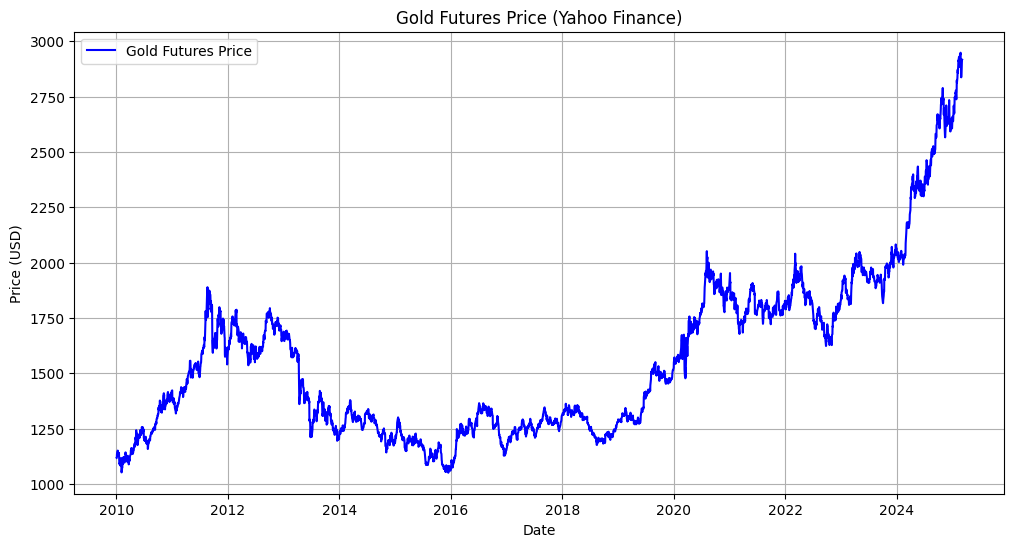

In [5]:
plt.figure(figsize=(12, 6))
plt.plot( df['Close'], label="Gold Futures Price", color='blue')

# Formatting the plot
plt.title("Gold Futures Price (Yahoo Finance)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.legend()

# Display the plot
plt.show()

In [6]:
df

Price,Close,High,Low,Open,Volume
Ticker,GC=F,GC=F,GC=F,GC=F,GC=F
Date,,,,,
2010-01-04,1117.699951,1122.300049,1097.099976,1117.699951,184
2010-01-05,1118.099976,1126.500000,1115.000000,1118.099976,53
2010-01-06,1135.900024,1139.199951,1120.699951,1135.900024,363
2010-01-07,1133.099976,1133.099976,1129.199951,1133.099976,56
2010-01-08,1138.199951,1138.199951,1122.699951,1138.199951,54
...,...,...,...,...,...
2025-02-28,2836.800049,2877.100098,2834.100098,2877.100098,990
2025-03-03,2890.199951,2891.800049,2863.399902,2872.699951,423


# Spliting the dataset into training (70%) and testing (30%) set

In [7]:
# Splitting data into training and testing

train = pd.DataFrame(df[0:int(len(df)*0.70)])
test = pd.DataFrame(df[int(len(df)*0.70): int(len(df))])

print(train.shape)
print(test.shape)

(2671, 5)
(1145, 5)


In [8]:
train.head()

Price,Close,High,Low,Open,Volume
Ticker,GC=F,GC=F,GC=F,GC=F,GC=F
Date,,,,,
2010-01-04,1117.699951,1122.300049,1097.099976,1117.699951,184
2010-01-05,1118.099976,1126.500000,1115.000000,1118.099976,53
2010-01-06,1135.900024,1139.199951,1120.699951,1135.900024,363
2010-01-07,1133.099976,1133.099976,1129.199951,1133.099976,56
2010-01-08,1138.199951,1138.199951,1122.699951,1138.199951,54


In [9]:
test.head()

Price,Close,High,Low,Open,Volume
Ticker,GC=F,GC=F,GC=F,GC=F,GC=F
Date,,,,,
2020-08-18,1999.400024,2002.800049,1972.099976,2001.099976,92
2020-08-19,1958.699951,1980.000000,1938.699951,1980.000000,347
2020-08-20,1933.800049,1948.300049,1922.300049,1941.199951,106
2020-08-21,1934.599976,1945.000000,1908.900024,1941.000000,184
2020-08-24,1927.699951,1940.000000,1922.199951,1930.199951,85


# Using MinMaxScaler on the dataset

---



In [10]:
from sklearn.preprocessing import MinMaxScaler

In [31]:
train_close = train.iloc[:, 1:2].values # 70% close prices for training 
test_close = test.iloc[:, 1:2].values # 30% close prices for testing
print(train_close)
print(test_close) #these really show that we are selecting the correct column

[[1122.30004883]
 [1126.5       ]
 [1139.19995117]
 ...
 [1957.40002441]
 [1947.40002441]
 [1985.        ]]
[[2002.80004883]
 [1980.        ]
 [1948.30004883]
 ...
 [2927.89990234]
 [2922.        ]
 [2918.60009766]]


In [32]:
minmax_scaler = MinMaxScaler(feature_range=(0,1))
data_training_array = minmax_scaler.fit_transform(train_close)

In [33]:
#Creating a Sliding Window for non-stationary data
x_train = []
y_train = [] 

for i in range(100, data_training_array.shape[0]):
    x_train.append(data_training_array[i-100: i])
    y_train.append(data_training_array[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train) 

In [34]:
x_train.shape

(2571, 100, 1)

# ML Model (LSTM)

---



In [35]:
from tensorflow.keras.layers import Dense, Dropout, LSTM,GRU
from tensorflow.keras.models import Sequential

In [68]:
model = Sequential()
model.add(LSTM(units = 50, activation = 'relu', return_sequences=True
              ,input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))


model.add(LSTM(units = 60, activation = 'relu', return_sequences=True))
model.add(Dropout(0.3))


model.add(LSTM(units = 80, activation = 'relu', return_sequences=True))
model.add(Dropout(0.4))


model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(units = 1))

c:\Users\lostinhaze\anaconda3\envs\eda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [69]:
gru_model = Sequential()

gru_model.add(GRU(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
gru_model.add(Dropout(0.2))

gru_model.add(GRU(60, return_sequences=True))
gru_model.add(Dropout(0.3))

gru_model.add(GRU(80, return_sequences=True))
gru_model.add(Dropout(0.4))

gru_model.add(GRU(120))
gru_model.add(Dropout(0.5))

gru_model.add(Dense(units=1))

gru_model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.MeanAbsoluteError()])



In [70]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 60)        │        26,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 60)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100, 80)        │        45,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 120)            │        96,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,761 (698.29 KB)

 Trainable params: 178,761 (698.29 KB)

 Non-trainable params: 0 (0.00 B)

In [71]:
gru_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 100, 50)        │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 100, 60)        │        20,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100, 60)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 100, 80)        │        34,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 100, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 120)            │        72,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 135,031 (527.46 KB)

 Trainable params: 135,031 (527.46 KB)

 Non-trainable params: 0 (0.00 B)

# Training the model

---



In [74]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=[tf.keras.metrics.MeanAbsoluteError()])
lstm_history = model.fit(x_train, y_train,epochs = 100)

Epoch 1/100


81/81 ━━━━━━━━━━━━━━━━━━━━ 29s 246ms/step - loss: 0.0108 - mean_absolute_error: 0.0782
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 17s 213ms/step - loss: 0.0067 - mean_absolute_error: 0.0585
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 18s 228ms/step - loss: 0.0055 - mean_absolute_error: 0.0544
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 19s 238ms/step - loss: 0.0050 - mean_absolute_error: 0.0511
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 19s 238ms/step - loss: 0.0046 - mean_absolute_error: 0.0481
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 319ms/step - loss: 0.0043 - mean_absolute_error: 0.0471
Epoch 7/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 19s 236ms/step - loss: 0.0037 - mean_absolute_error: 0.0438
Epoch 8/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 19s 229ms/step - loss: 0.0034 - mean_absolute_error: 0.0417
Epoch 9/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 18s 222ms/step - loss: 0.0036 - mean_absolute_error: 0.0415
Epoch 10/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 19s 235ms/step - loss: 0.0034 - mean_absolute_error: 0.0418
Epoch 11/100
81/81 ━━

In [75]:
gru_history = gru_model.fit(x_train, y_train,epochs = 100)

Epoch 1/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 31s 237ms/step - loss: 0.0241 - mean_absolute_error: 0.1042
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 19s 230ms/step - loss: 0.0034 - mean_absolute_error: 0.0408
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 19s 238ms/step - loss: 0.0028 - mean_absolute_error: 0.0374
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 19s 230ms/step - loss: 0.0027 - mean_absolute_error: 0.0365
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 19s 237ms/step - loss: 0.0027 - mean_absolute_error: 0.0379
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 19s 235ms/step - loss: 0.0022 - mean_absolute_error: 0.0338
Epoch 7/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 248ms/step - loss: 0.0022 - mean_absolute_error: 0.0340
Epoch 8/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 253ms/step - loss: 0.0020 - mean_absolute_error: 0.0326
Epoch 9/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 251ms/step - loss: 0.0025 - mean_absolute_error: 0.0358
Epoch 10/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 244ms/step - loss: 0.0023 - mean_absolute_error: 0.0346
Epoch 11/

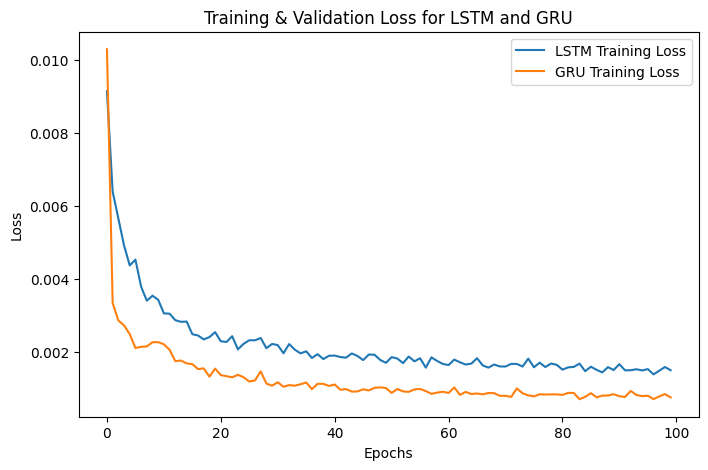

In [77]:

# Convert history to DataFrame
lstm_df = pd.DataFrame(lstm_history.history)
gru_df = pd.DataFrame(gru_history.history)

# Plot both losses on the same figure
plt.figure(figsize=(8, 5))
plt.plot(lstm_df["loss"], label="LSTM Training Loss")
plt.plot(gru_df["loss"], label="GRU Training Loss")
# Labels and title
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss for LSTM and GRU")
plt.legend()
plt.show()


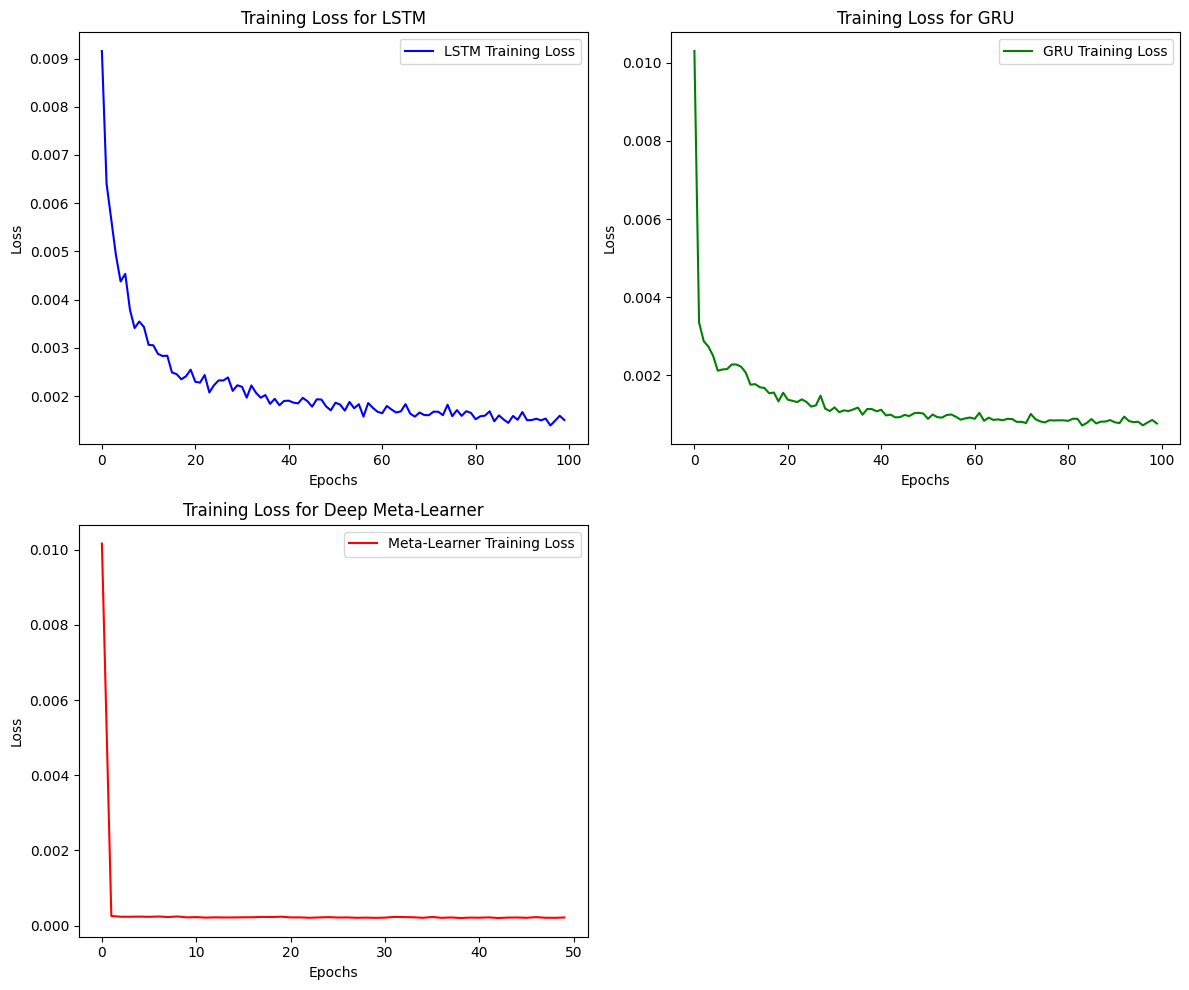

In [79]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert history to DataFrame
lstm_df = pd.DataFrame(lstm_history.history)
gru_df = pd.DataFrame(gru_history.history)
meta_df = pd.DataFrame(history.history)  # Third model

# Create subplots (2 columns, 2 rows: last plot spans both columns)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2 rows, 2 columns

# LSTM Training Loss Plot (Top-Left)
axes[0, 0].plot(lstm_df["loss"], label="LSTM Training Loss", color="blue")
axes[0, 0].set_title("Training Loss for LSTM")
axes[0, 0].set_xlabel("Epochs")
axes[0, 0].set_ylabel("Loss")
axes[0, 0].legend()

# GRU Training Loss Plot (Top-Right)
axes[0, 1].plot(gru_df["loss"], label="GRU Training Loss", color="green")
axes[0, 1].set_title("Training Loss for GRU")
axes[0, 1].set_xlabel("Epochs")
axes[0, 1].set_ylabel("Loss")
axes[0, 1].legend()

# Meta-Learner Training Loss Plot (Bottom, spans both columns)
axes[1, 0].plot(meta_df["loss"], label="Meta-Learner Training Loss", color="red")
axes[1, 0].set_title("Training Loss for Deep Meta-Learner")
axes[1, 0].set_xlabel("Epochs")
axes[1, 0].set_ylabel("Loss")
axes[1, 0].legend()

# Hide unused subplot (bottom-right)
fig.delaxes(axes[1, 1])

# Adjust layout
plt.tight_layout()
plt.show()


In [74]:
model.save('lstm_model.keras')

In [75]:
gru_model.save('gru_model.keras')

In [36]:
from tensorflow.keras.models import load_model
lstm_model_path = "./lstm_model.keras"  # Path to your saved model
gru_model_path  = "./gru_model.keras"
lstm_model = load_model(lstm_model_path)
gru_model = load_model(gru_model_path)
print("Models Loaded Successfully!")

Models Loaded Successfully!


In [37]:
test_close.shape

(1145, 1)

In [38]:
past_100_days = pd.DataFrame(train_close[-100:])

In [39]:
test_df = pd.DataFrame(test_close)

**Defining the final dataset for testing by including last 100 coloums of the training dataset to get the prediction from the 1st column of the testing dataset.**

---


In [40]:
final_df = pd.concat([past_100_days, test_df], ignore_index=True)

In [41]:
final_df.head()
final_df.tail()

,0
1240,2877.100098
1241,2891.800049
1242,2927.899902
1243,2922.000000
1244,2918.600098


In [42]:
input_data = minmax_scaler.fit_transform(final_df)
input_data

array([[0.04455409],
       [0.01760073],
       [0.03888361],
       ...,
       [0.97790706],
       [0.97356219],
       [0.97105839]])

In [43]:
input_data.shape

(1245, 1)

# Testing the model

---



In [94]:
x_test = []
y_test = []
for i in range(100, input_data.shape[0]):
   x_test.append(input_data[i-100: i])
   y_test.append(input_data[i, 0])

In [95]:
x_test, y_test = np.array(x_test), np.array(y_test)
print(x_test.shape)
print(y_test.shape)

(1145, 100, 1)
(1145,)


# Making prediction and plotting the graph of predicted vs actual values

---



In [96]:
# Making predictions

gru_pred = gru_model.predict(x_test)
lstm_pred = lstm_model.predict(x_test)

36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 191ms/step


In [97]:
#standard_scaler.scale_


In [98]:
# scale_factor = 1/0.00041967
# y_pred = y_pred * scale_factor
# y_test = y_test * scale_factor
y_test = minmax_scaler.inverse_transform(y_test.reshape(-1, 1))
gru_pred = minmax_scaler.inverse_transform(gru_pred)
lstm_pred = minmax_scaler.inverse_transform(lstm_pred)

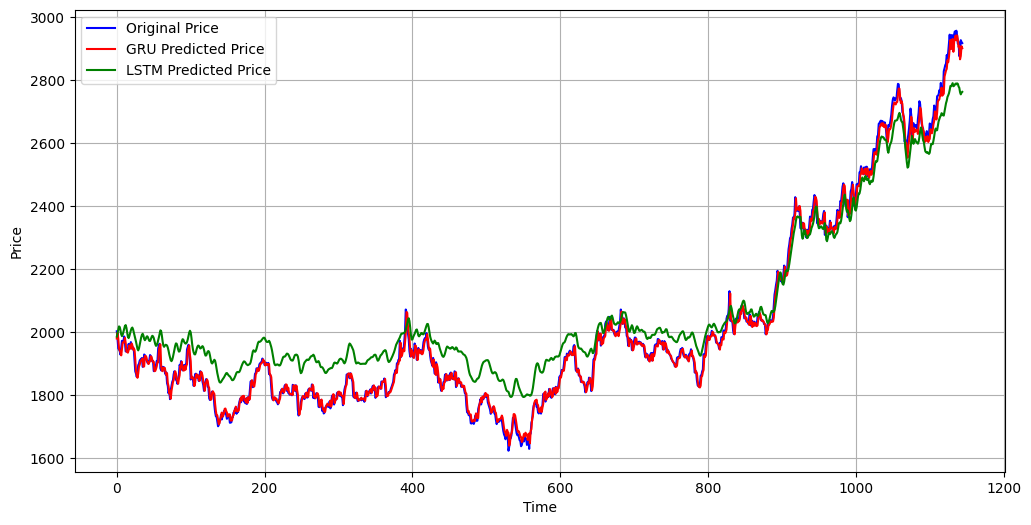

In [99]:
plt.figure(figsize = (12,6))
plt.plot(y_test, 'b', label = "Original Price")
plt.plot(gru_pred, 'r', label = "GRU Predicted Price")
plt.plot(lstm_pred, 'g', label = "LSTM Predicted Price")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error , mean_absolute_error, root_mean_squared_error , mean_absolute_percentage_error

mse = mean_squared_error(y_test, lstm_pred)
mae = mean_absolute_error(y_test, lstm_pred)
rmse = root_mean_squared_error(y_test, lstm_pred)
mape = mean_absolute_percentage_error(y_test, lstm_pred)
print('For LSTM Model')
print("Mean squared error on test set: {:.2f}".format(mse))
print("Mean absolute error on test set: {:.2f}".format(mae))
print("Root mean squared error on test set: {:.2f}".format(rmse))
print("Mean absolute percentage error on test set: {:.2f}".format(mape))

print('\n\n')

mse = mean_squared_error(y_test, gru_pred)
mae = mean_absolute_error(y_test, gru_pred)
rmse = root_mean_squared_error(y_test, gru_pred)
mape = mean_absolute_percentage_error(y_test, gru_pred)
print('For GRU Model')
print("Mean squared error on test set: {:.2f}".format(mse))
print("Mean absolute error on test set: {:.2f}".format(mae))
print("Root mean squared error on test set: {:.2f}".format(rmse))
print("Mean absolute percentage error on test set: {:.2f}".format(mape))

For LSTM Model
Mean squared error on test set: 7563.67
Mean absolute error on test set: 76.63
Root mean squared error on test set: 86.97
Mean absolute percentage error on test set: 0.04



For GRU Model
Mean squared error on test set: 353.20
Mean absolute error on test set: 13.94
Root mean squared error on test set: 18.79
Mean absolute percentage error on test set: 0.01


: 

# ENSEMBLING

# XGBOOST

In [50]:
import numpy as np
from xgboost import XGBRegressor

# Train LSTM and GRU separately
lstm_preds_train = lstm_model.predict(x_train)
gru_preds_train = gru_model.predict(x_train)

# Use LSTM and GRU outputs as features
stacked_train = np.column_stack((lstm_preds_train, gru_preds_train))

# Train a Meta-Learner (XGBoost)
meta_learner = XGBRegressor(
    n_estimators=300,  # Increase number of trees
    learning_rate=0.1,  # Slightly higher learning rate
    max_depth=6,  # Increase tree depth
    gamma=0,  # Reduce regularization
    reg_lambda=1,  # Adjust L2 regularization
    subsample=0.9,  # Add randomness to training
)

meta_learner.fit(stacked_train, y_train)

# Generate test predictions
lstm_preds_test = lstm_model.predict(x_test)
gru_preds_test = gru_model.predict(x_test)

# Combine predictions
stacked_test = np.column_stack((lstm_preds_test, gru_preds_test))

# Final prediction
final_preds = meta_learner.predict(stacked_test)


81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step


In [51]:
meta_learner.save_model("final_model.json")

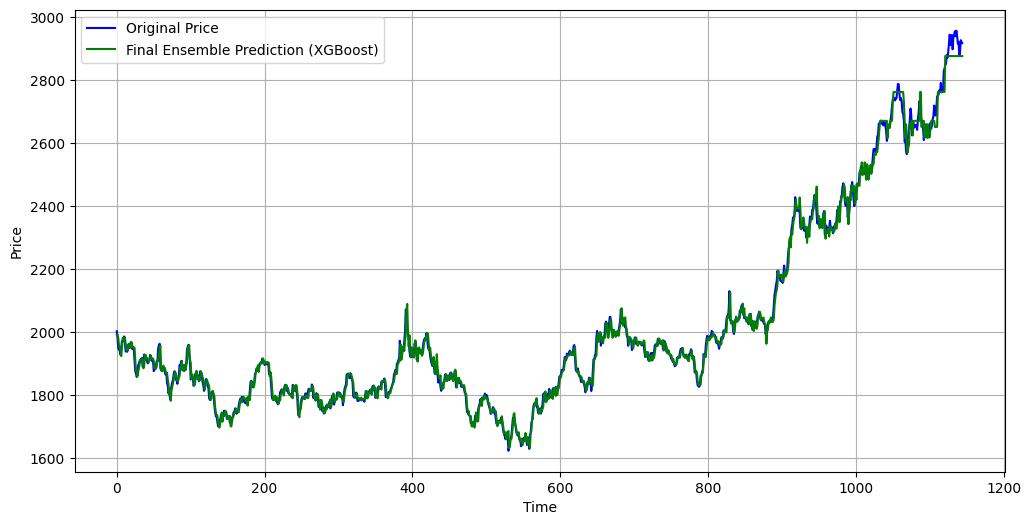

In [52]:
# Inverse transform the predictions
final_preds = final_preds.reshape(-1, 1)  # Reshape for scaler
final_preds = minmax_scaler.inverse_transform(final_preds)  # Inverse transform

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test, 'b', label="Original Price")
plt.plot(final_preds, 'g', label="Final Ensemble Prediction (XGBoost)")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


# ATTENTION MECHANISM

In [53]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Multiply 
from tensorflow.keras.models import Sequential


# Define attention mechanism
attention = Dense(2, activation='softmax')(stacked_train)  # Two models (LSTM, GRU)
weighted_preds = Multiply()([stacked_train, attention])

# Final meta-model
meta_model = Sequential([
    Dense(32, activation='relu', input_shape=(2,)), 
    Dense(16, activation='relu'),
    Dense(1)  # Final prediction
])
meta_model.compile(optimizer='adam', loss='mse')
meta_model.fit(weighted_preds, y_train, epochs=50, batch_size=16, verbose=1)

# Predict
attention_test = Dense(2, activation='softmax')(stacked_test)
weighted_test = Multiply()([stacked_test, attention_test])
final_preds = meta_model.predict(weighted_test)


Epoch 1/50


c:\Users\lostinhaze\anaconda3\envs\eda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0033
Epoch 2/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.2641e-04
Epoch 3/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0621e-04
Epoch 4/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1525e-04
Epoch 5/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9248e-04
Epoch 6/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0632e-04
Epoch 7/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9321e-04
Epoch 8/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9593e-04
Epoch 9/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0418e-04
Epoch 10/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0750e-04
Epoch 11/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8698e-04
Epoch 12/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0902e-04
Epoch 13/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1585e-04
Epoch 14/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0434e-04
Epoch 15/50
161/

In [54]:
meta_model.save("final_attention_model.keras")

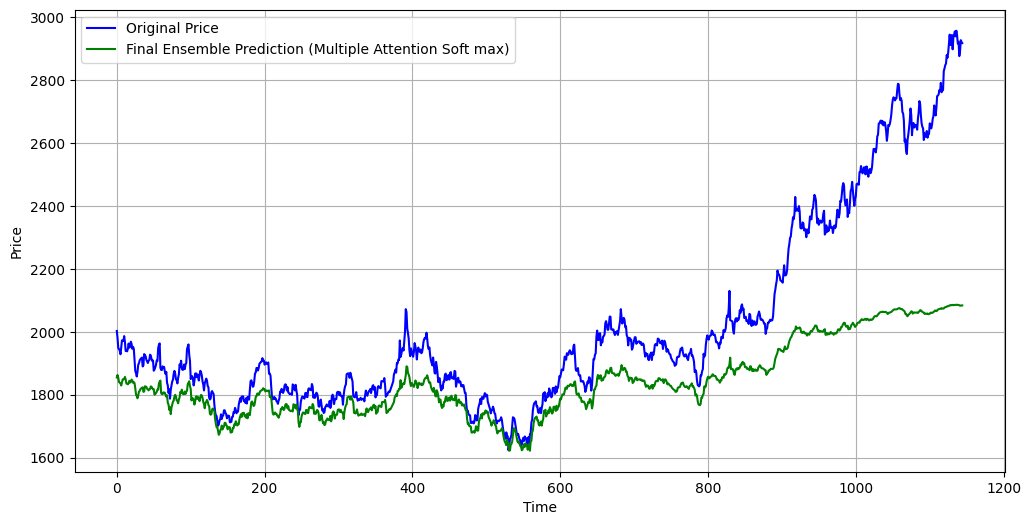

In [55]:
final_preds = final_preds.reshape(-1, 1)  # Reshape for scaler
final_preds = minmax_scaler.inverse_transform(final_preds)  # Inverse transform

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test, 'b', label="Original Price")
plt.plot(final_preds, 'g', label="Final Ensemble Prediction (Multiple Attention Soft max)")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# DEEP LEARNING META LEARNER

In [100]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Prepare stacked train and test datasets
stacked_train = np.column_stack((lstm_preds_train, gru_preds_train))
stacked_test = np.column_stack((lstm_preds_test, gru_preds_test))

# Define Meta-Learner (MLP)
meta_model = Sequential([
    Dense(64, activation='relu', input_shape=(2,)),  # Two input features (LSTM, GRU)
    Dense(32, activation='relu'),
    Dense(1)  # Final price prediction
])

meta_model.compile(optimizer='adam', loss='mse')
history =meta_model.fit(stacked_train, y_train, epochs=50, batch_size=16, verbose=1)

# Predict final ensemble output
final_preds = meta_model.predict(stacked_test)


Epoch 1/50


c:\Users\lostinhaze\anaconda3\envs\eda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


161/161 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0357
Epoch 2/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.7922e-04
Epoch 3/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.2872e-04
Epoch 4/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.2397e-04
Epoch 5/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.3332e-04
Epoch 6/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.2329e-04
Epoch 7/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.1459e-04
Epoch 8/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.1246e-04
Epoch 9/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.2741e-04
Epoch 10/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.2967e-04
Epoch 11/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.0984e-04
Epoch 12/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.9480e-04
Epoch 13/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.0085e-04
Epoch 14/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.3896e-04
Epoch 15/50
161/

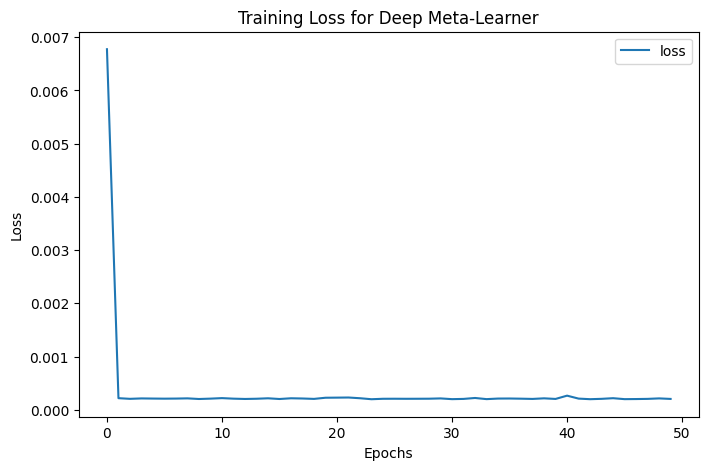

In [83]:
# Convert history to DataFrame and plot
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss for Deep Meta-Learner")
plt.show()

In [87]:
final_preds

array([[0.28038653],
       [0.2906843 ],
       [0.28707965],
       ...,
       [0.93125283],
       [0.94382967],
       [0.94265623]])

In [88]:
meta_model.save("final_mlp_model.keras")

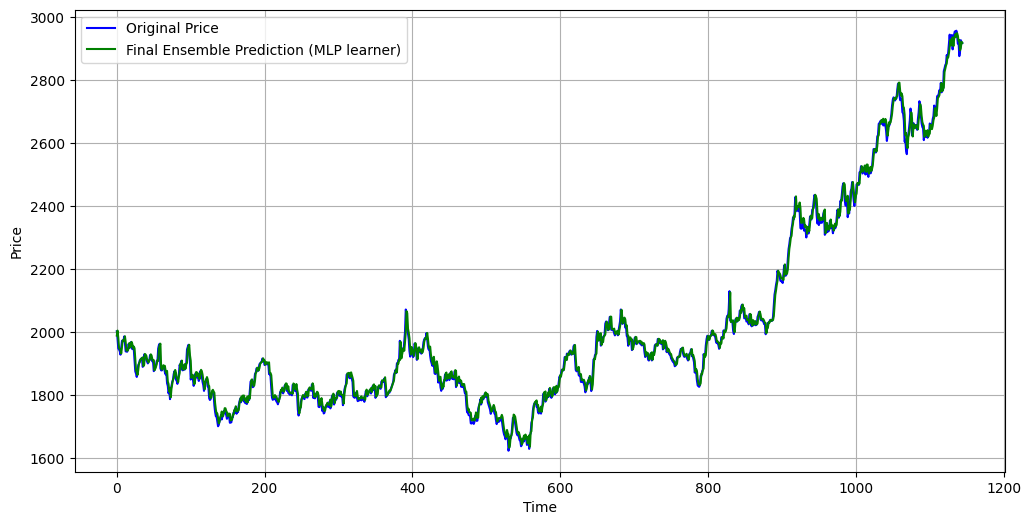

In [101]:
final_preds = final_preds.reshape(-1, 1)  # Reshape for scaler
final_preds_inversed = minmax_scaler.inverse_transform(final_preds)  # Inverse transform

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test, 'b', label="Original Price")
plt.plot(final_preds_inversed, 'g', label="Final Ensemble Prediction (MLP learner)")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [103]:
from sklearn.metrics import mean_squared_error , mean_absolute_error, root_mean_squared_error , mean_absolute_percentage_error

mse = mean_squared_error(y_test, final_preds_inversed)
mae = mean_absolute_error(y_test, final_preds_inversed)
rmse = root_mean_squared_error(y_test, final_preds_inversed)
mape = mean_absolute_percentage_error(y_test, final_preds_inversed)
print("Mean squared error on test set: {:.2f}".format(mse))
print("Mean absolute error on test set: {:.2f}".format(mae))
print("Root mean squared error on test set: {:.2f}".format(rmse))
print("Mean absolute percentage error on test set: {:.2f}".format(mape))

Mean squared error on test set: 332.11
Mean absolute error on test set: 13.47
Root mean squared error on test set: 18.22
Mean absolute percentage error on test set: 0.01


# WEIGHTED AVERAGE DYNAMIC WEIGHTS

In [86]:
# Compute errors of LSTM and GRU
lstm_error = np.abs(y_test - lstm_preds_test)
gru_error = np.abs(y_test - gru_preds_test)

# Compute weights (lower error = higher weight)
lstm_weight = 1 / (lstm_error + 1e-8)
gru_weight = 1 / (gru_error + 1e-8)

# Normalize weights
total_weight = lstm_weight + gru_weight
lstm_weight /= total_weight
gru_weight /= total_weight

# Compute weighted predictions
final_preds = lstm_weight * lstm_preds_test + gru_weight * gru_preds_test


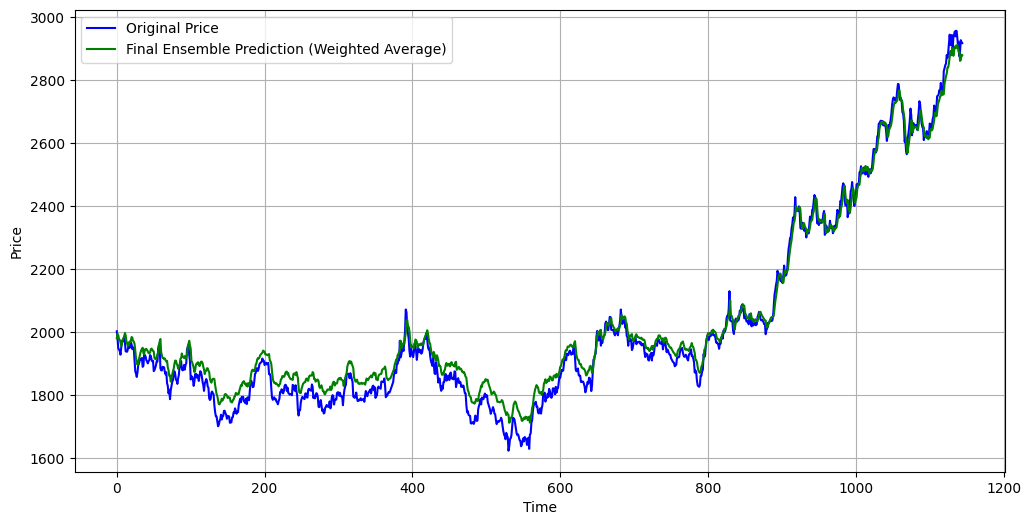

In [61]:
final_preds = final_preds.reshape(-1, 1)  # Reshape for scaler
final_preds = minmax_scaler.inverse_transform(final_preds)  # Inverse transform

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test, 'b', label="Original Price")
plt.plot(final_preds, 'g', label="Final Ensemble Prediction (Weighted Average)")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# BAYESIAN MODEL AVERAGING

In [62]:
from pydlm import dlm, trend, seasonality

# Define the model
model = dlm(y_train) + trend(degree=1) + seasonality(period=30)
model.fit()

# Get weights for each model dynamically
lstm_prob = model.getLatentState(filterType='forwardFilter', name='trend')[0][0]  
gru_prob = model.getLatentState(filterType='forwardFilter', name='seasonality')[0][0]  

# Normalize probabilities
total_prob = lstm_prob + gru_prob
lstm_prob /= total_prob
gru_prob /= total_prob

# Compute Bayesian weighted average
final_preds = lstm_prob * lstm_preds_test + gru_prob * gru_preds_test


INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.


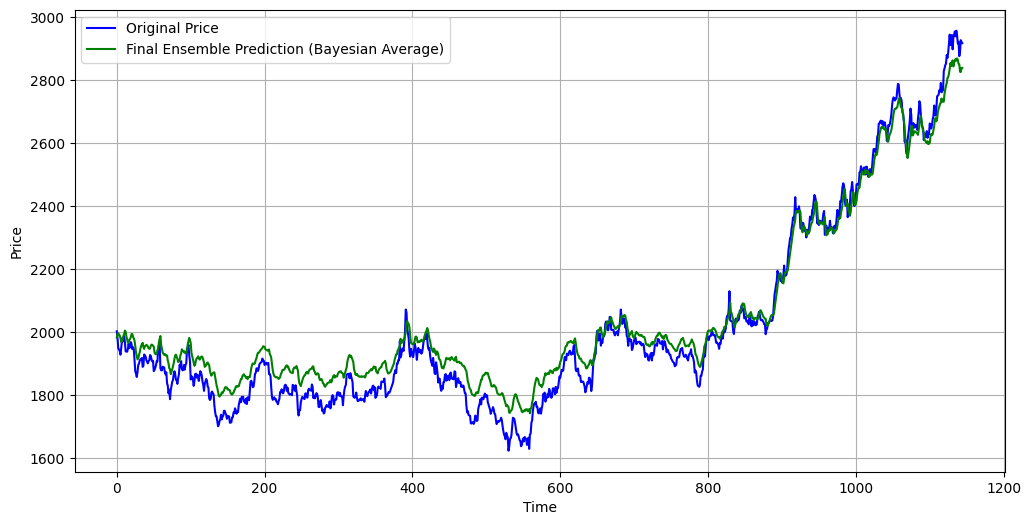

In [63]:
final_preds = final_preds.reshape(-1, 1)  # Reshape for scaler
final_preds = minmax_scaler.inverse_transform(final_preds)  # Inverse transform

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test, 'b', label="Original Price")
plt.plot(final_preds, 'g', label="Final Ensemble Prediction (Bayesian Average)")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Model evaluation

Calculation of mean absolute error

In [81]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, final_preds)

print("Mean absolute error on test set: {:.2f}".format(mse))


Mean absolute error on test set: 4163435.46


Calculation of R2 score

In [117]:
from sklearn.metrics import r2_score 

# Actual values
actual = y_test

# Predicted values
predicted = y_pred

# Calculate the R2 score
r2 = r2_score(predicted, actual)
print("R2 score:", r2)

R2 score: -73.29885279091395


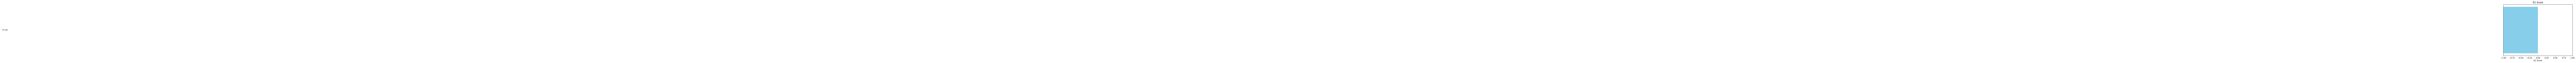

In [119]:
# Plotting the R2 score
fig, ax = plt.subplots()
ax.barh(0, r2, color='skyblue')
ax.set_xlim([-1, 1])
ax.set_yticks([])
ax.set_xlabel('R2 Score')
ax.set_title('R2 Score')

# Adding the R2 score value on the bar
ax.text(r2, 0, f'{r2:.2f}', va='center', color='black')

plt.show()

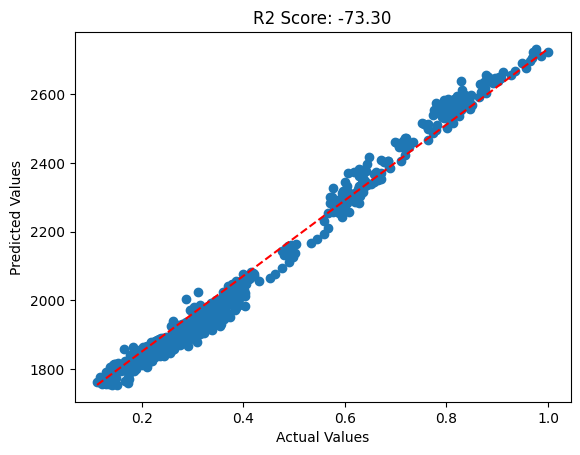

In [120]:
plt.scatter(actual, predicted)
plt.plot([min(actual), max(actual)], [min(predicted), max(predicted)], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'R2 Score: {r2:.2f}')
plt.show()